# Reading and processing spectral data (Rainbow format)

Spectral data is 3-dimensional radar obtained from the FFT of the IQ data. It has the following dimensions:

*number of rays* X *number of range bins* X *number of velocity bins*

whereas normal radar moments (that can be obtained by integrating on the last dimension of the spectrum) have only the dimensions

*number of rays* X *number of range bins*

Therefore, spectral data are treated differently in Py-ART and have their own reader and processing routines

To read spectral data and to create a Spectrum Py-ART object (similar to the normal Radar object but for spectral data) in the Raibow format you need to use the function [read_rainbow_psr_spectra](https://meteoswiss.github.io/pyart/API/generated/pyart.aux_io.read_rainbow_psr_spectra.html#pyart-aux-io-read-rainbow-psr-spectra). 

This reader requires you to provide a normal Rainbow file as well as one or more PSR (spectral files). The function will then use the normal rainbow file as a reference and will look for the spectrum data from all the provided files that matches the timestamps and angles in the normal rainbow file. The more files you provide as spectral files, the longer the reading will take, so it is good to filter a bit the relevant files yourself before.

In the example below we provide only the spectral files which have exactly the same timestamps in the filename as the original file.

In [67]:
import pyart
import glob
import os
import matplotlib.pyplot as plt
import cmweather
import numpy as np

os.environ["PSRLIB_PATH"] = "/home/malsplus/radarVgit/src/libDX50//lib/"
file_wrl = "/data/CAMPAIGNS/MEIRINGEN_2024/Instruments/50DX/Raw/MEI24_VERTPPI_el90_psr.azi/2025-06-02/2025060212462800dBZ.azi"
files_psr = glob.glob("/data/CAMPAIGNS/MEIRINGEN_2024/Instruments/50DX/PSR/MEI24_VERTPPI_el90_psr.azi/2025-06-02/202506021246*.ufh.psr.rd")
spectrum = pyart.aux_io.read_rainbow_psr_spectra(file_wrl, files_psr)

In [68]:
print(spectrum.fields.keys())

dict_keys(['transmitted_power_h', 'transmitted_power_v', 'spectral_noise_power_hh_ADU', 'spectral_noise_power_vv_ADU', 'spectral_noise_power_hv_ADU', 'spectral_noise_power_vh_ADU', 'complex_spectra_hh_ADU', 'complex_spectra_vv_ADU'])


## Compute additional fields

### Spectral power

Spectral power is computed by taking the norm of the complex spectrum in ADU. Optionally it can convert it to another unit (dBADU or dBm) and subtract noise from the power.

In our case we will compute it in dBm

In [69]:
spectral_power = pyart.retrieve.spectra.compute_spectral_power(spectrum, units="dBm", subtract_noise=True)

Add it to the spectrum objet

In [70]:
spectrum.fields["spectral_power_hh_dBm"] = spectral_power

### Spectral reflectivity

The spectral reflectivity requires the spectral power, you can either, first compute the spectral power and use it in the call to the function or you can do both at once. We will do both at once. 

See [compute_spectral_reflectivity](https://meteoswiss.github.io/pyart/API/generated/pyart.retrieve.compute_spectral_reflectivity.html#pyart.retrieve.compute_spectral_reflectivity) for more information

In [71]:
spectral_refl = pyart.retrieve.spectra.compute_spectral_reflectivity(spectrum, compute_power=True, subtract_noise=True)
spectrum.fields["spectral_reflectivity_hh"] = spectral_refl

*Similar functions exist for other spectral variables for example [compute_spectral_phase](https://meteoswiss.github.io/pyart/API/generated/pyart.retrieve.compute_spectral_phase.html#pyart.retrieve.compute_spectral_phase) or [compute_spectral_differential_phase](https://meteoswiss.github.io/pyart/API/generated/pyart.retrieve.compute_spectral_differential_reflectivity.html#pyart.retrieve.compute_spectral_differential_reflectivity)*

In [72]:
print(spectrum.fields["spectral_reflectivity_hh"]["data"].shape)
print(spectrum.nrays)
print(spectrum.npulses_max)
print(spectrum.ngates)

(360, 500, 168)
360
168
500


Dimensions of spectral data is 

nrays x npulses x ngates

npulses is the length of the FFT, so the number of velocity bins.

Velocity bins can be accesses with

Text(0.5, 0, 'Range gate index')

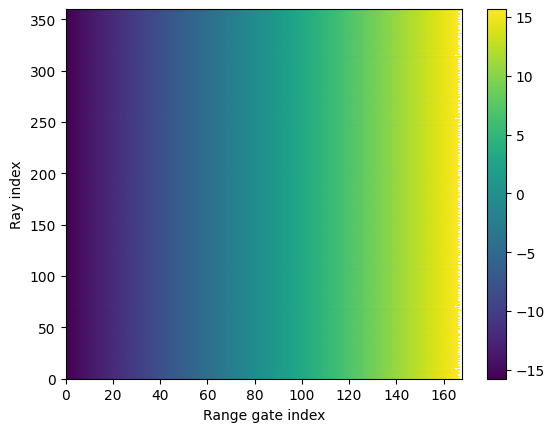

In [73]:
vel_bins = spectrum.Doppler_velocity["data"]

plt.figure()
plt.pcolormesh(vel_bins)
plt.colorbar()
plt.ylabel("Ray index")
plt.xlabel("Range gate index")

Note that typically the velocity bins are the same for all rays, as can be seen above

## Radar moments

All radar moments can be derived from the spectrum, you can either use the corresponding function for example [compute_reflectivity](https://meteoswiss.github.io/pyart/API/generated/pyart.retrieve.compute_reflectivity.html#pyart.retrieve.compute_reflectivity) or [compute_differential_reflectivity](https://meteoswiss.github.io/pyart/API/generated/pyart.retrieve.compute_differential_reflectivity.html#pyart.retrieve.compute_differential_reflectivity) or compute several at once [compute_pol_variables](https://meteoswiss.github.io/pyart/API/generated/pyart.retrieve.compute_pol_variables.html#pyart.retrieve.compute_pol_variables) to create a classical radar object.

In [74]:
radar = pyart.retrieve.spectra.compute_pol_variables(spectrum, ["reflectivity", "differential_reflectivity"], subtract_noise=True)

## Make a plot of the spectral reflectivity

Text(0, 0.5, 'Altitude [km]')

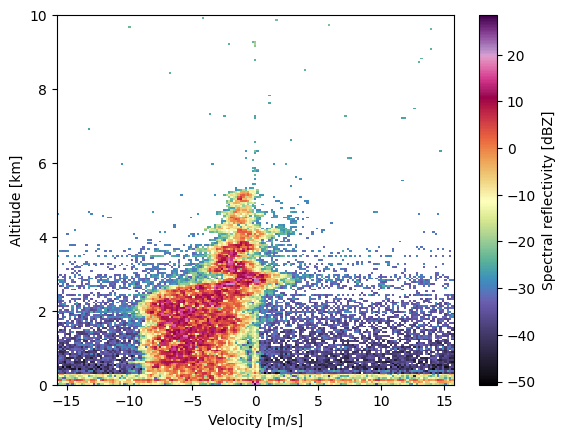

In [75]:
ray = 0

xaxis = spectrum.Doppler_velocity["data"][ray].compressed()

xres = np.abs(xaxis[1] - xaxis[0])

yaxis = spectrum.range["data"] / 1000.0
yres = np.abs(yaxis[1] - yaxis[0])
xaxis_lim = np.append(xaxis - xres / 2, xaxis[-1] + xres / 2)
yaxis_lim = np.append(yaxis - yres / 2, yaxis[-1] + yres / 2)

field_2D = spectrum.fields["spectral_reflectivity_hh"]["data"][ray, :, 0 : vel_bins_ray.size]
 
X, Y = np.meshgrid(xaxis_lim, yaxis_lim)

plt.pcolormesh(X,Y, field_2D, cmap = cmweather.cm_colorblind.ChaseSpectral)
plt.colorbar(label = "Spectral reflectivity [dBZ]")
plt.ylim([0,10])
plt.xlabel("Velocity [m/s]")
plt.ylabel("Altitude [km]")